In [1]:
#############################################################################
###Implementation manuelle du NN
###
#############################################################################


from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NN:
    def __init__(self, train_data, valid_data, test_data, L=2, lr=0.001, batchSize=1000, epoch=150, hidden_layer_size = 300):
        self.W = []
        self.best_W = []
        self.losses = []
        self.best_accuracy = 0
        self.accuracies = []
        self.L = L
        self.lr = lr
        self.nb_epochs = epoch
        self.nb_batches = batchSize
        self.hidden_layer_size = hidden_layer_size
        
        self.K = len(np.unique(train_data.dataset.targets))

        self.X_train = np.reshape(train_data.dataset.data, (train_data.dataset.data.shape[0], train_data.dataset.data.shape[1]*train_data.dataset.data.shape[2]))
        self.X_valid = np.reshape(valid_data.dataset.data, (valid_data.dataset.data.shape[0], valid_data.dataset.data.shape[1]*valid_data.dataset.data.shape[2]))
        self.X_test = np.reshape(test_data.dataset.data, (test_data.dataset.data.shape[0], test_data.dataset.data.shape[1]*test_data.dataset.data.shape[2]))
        
        self.Y_train = np.zeros((train_data.dataset.targets.shape[0], self.K))
        self.Y_train[np.arange(self.Y_train.shape[0]), train_data.dataset.targets] = 1
        
        self.Y_valid = np.zeros((valid_data.dataset.targets.shape[0], self.K))
        self.Y_valid[np.arange(self.Y_valid.shape[0]), valid_data.dataset.targets] = 1
        
        self.Y_test = np.zeros((test_data.dataset.targets.shape[0], self.K))
        self.Y_test[np.arange(self.Y_test.shape[0]), test_data.dataset.targets] = 1
        
        
        self.set_w()

    
    def set_w(self):
        self.W.append(np.random.normal(0, 0.01, (self.X_train.shape[1]+1, self.hidden_layer_size)))
        for i in range(self.L-1):
            self.W.append(np.random.normal(0, 0.01, (self.hidden_layer_size+1, self.hidden_layer_size)))
        self.W.append(np.random.normal(0, 0.01, (self.hidden_layer_size+1, self.K)))
    
    
    def softmax(self, z):
        exp = np.exp(z - z.max(1)[:,np.newaxis])
        return np.array(exp / exp.sum(1)[:,np.newaxis])
    
    
    def softmax_derivative(self, a):
        return a * (1-a)
    
    
    def ReLU(self, z):
        return np.maximum(z, 0)
    
    
    def ReLU_derivative(self, z):
        return (z >= 0).astype(int)
    
    
    def get_loss(self, y, y_pred):
        return -np.sum(y * np.log(y_pred))
    
    
    def get_accuracy(self, y, y_pred):
        correct = 0
        for i in range(len(y_pred)):
            if np.argmax(y_pred[i]) == np.argmax(y[i]):
                correct += 1
        return correct / len(y)

    def fit(self):
        minibatch_size = len(self.X_train) // self.nb_batches
        for epoch in range(self.nb_epochs):
            permutaion = list(np.random.permutation(self.X_train.shape[0]))
            X_shuffle = self.X_train[permutaion]
            Y_shuffle = self.Y_train[permutaion]
            for batche in range(0, X_shuffle.shape[0], minibatch_size):
                Z = [None] * (self.L + 2)
                a = [None] * (self.L + 2)
                delta = [None] * (self.L + 2)
                X = X_shuffle[batche:batche+minibatch_size]
                Y = Y_shuffle[batche:batche+minibatch_size]
    
                #forward propagation
                a[0] = np.append(X, np.ones((len(X), 1)), axis=1)
                for i in range(self.L):
                    Z[i + 1] = a[i] @ self.W[i]
                    a[i + 1] = np.append(self.ReLU(Z[i+1]), np.ones((len(Z[i+1]), 1), dtype=int), axis=1)
    
                Z[-1] = a[self.L] @ self.W[self.L]
                a[-1] = self.softmax(Z[-1])
    
                #back propagation
                delta[-1] = (Y - a[-1]) * self.softmax_derivative(a[-1])
                for i in range(self.L, 0, -1):
                    delta[i] = (delta[i+1] @ self.W[i].T)[:,:-1] * self.ReLU_derivative(Z[i])
    
                for i in range(len(self.W)):
                    g = a[i].T @ delta[i+1] / len(delta[i+1])
                    self.W[i] = self.W[i] + self.lr * g
    
            self.valid()   

    def valid(self):        
        Z = [None] * (self.L + 2)
        a = [None] * (self.L + 2)
    
        a[0] = np.append(self.X_valid, np.ones((len(self.X_valid), 1)), axis=1)
        for i in range(self.L):
            Z[i + 1] = a[i] @ self.W[i]
            a[i + 1] = np.append(self.ReLU(Z[i+1]), np.ones((len(self.X_valid), 1)), axis=1)
    
        Z[-1] = a[self.L] @ self.W[self.L]
        a[-1] = self.softmax(Z[-1])
        loss = self.get_loss(self.Y_valid, a[-1])
        accuracy = self.get_accuracy(self.Y_valid, a[-1])
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.best_w = self.W.copy()
        self.accuracies.append(accuracy)
        self.losses.append(loss)
        
        
    def test(self):
        Z = [None] * (self.L + 2)
        a = [None] * (self.L + 2)
    
        a[0] = np.append(self.X_test, np.ones((len(self.X_test), 1)), axis=1)
        for i in range(self.L):
            Z[i + 1] = a[i] @ self.W[i]
            a[i + 1] = np.append(self.ReLU(Z[i+1]), np.ones((len(self.X_test), 1)), axis=1)
    
        Z[-1] = a[self.L] @ self.W[self.L]
        a[-1] = self.softmax(Z[-1])
        loss = self.get_loss(self.Y_test, a[-1])
        accuracy = self.get_accuracy(self.Y_test, a[-1])
        return accuracy, loss



In [3]:
#############################################################################
###Implementation pytorch du NN
###
#############################################################################

In [4]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision import datasets


train_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_data = datasets.FashionMNIST('../data', train=False, download=True,
                      transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
                   
train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)
train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]
mask = np.ones(60000)
mask[train_idx] = 0
valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]

batch_size = 1000

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=True)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


In [5]:
class FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 10)

    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [6]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return model


def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    # valid_loss /= len(valid_loader.dataset)
    return valid_loss, 1. * correct / len(valid_loader.dataset)


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print('\n' + "Pytorch test" + ' set: Total loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    return test_loss, 1. * correct / len(test_loader.dataset)

def fit(model, epochs=150, lr=0.001):
    best_model = model
    best_accuracy = 0
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        valid_loss, accuracy = valid(model, valid_loader)
        losses.append(valid_loss)
        accuracies.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    return best_model, best_accuracy


In [7]:
#############################################################################
###Execution implementation manuelle
###
#############################################################################
fashion_mnist = keras.datasets.fashion_mnist
train_data, test_data = fashion_mnist.load_data()

customnn = NN(train_loader, valid_loader, test_loader)
print("Algo imp")
print("START TRANING")
customnn.fit()
print("END TRAINING")

Algo imp
START TRANING
END TRAINING


In [8]:
#############################################################################
###Execution implementation pytorch
###
#############################################################################

losses = []
accuracies = []
best_model = None
best_accuracy = 0
print("Algo pytorch")
print("START TRAINIG")
model, accuracy = fit(FcNetwork())
print("END TRAINING")


Algo pytorch
START TRAINIG
END TRAINING


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


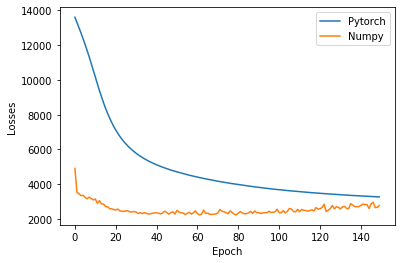

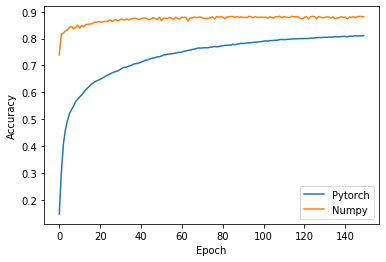

In [9]:
plt.plot(losses, label='Pytorch')
plt.plot(customnn.losses, label="Numpy")
plt.ylabel("Losses")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.plot(accuracies, label="Pytorch")
plt.plot(customnn.accuracies, label="Numpy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [10]:
test(model, test_loader)

result = customnn.test()
print('\n' + "Numpy test" + ' set: Total loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
        result[1], result[0]*100))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Pytorch test set: Total loss: 5564.8408, Accuracy: 80%


Numpy test set: Total loss: 4690.0995, Accuracy: 88%

